**IMPORTING LIBRARIES**

In [ ]:
import pandas as pd
import numpy as np
from pandas import read_csv
from matplotlib import pyplot
import statsmodels.api as sm
from pandas import DataFrame
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
import warnings
warnings.filterwarnings('ignore')
!pip install statsmodels 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


**LOADING DATA**

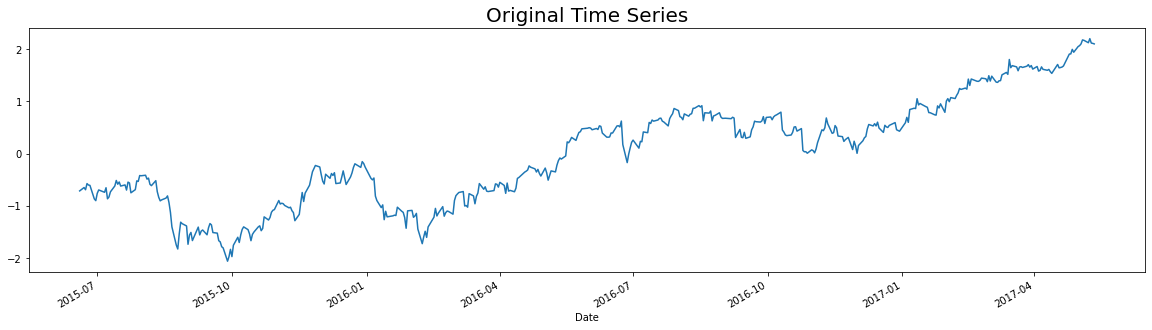

In [ ]:
series = read_csv('A.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)
series = series['Close']
series = np.log(series)
a = np.mean(series)
b = math.sqrt(np.var(series))
series = (series-a)/b
pyplot.title('Original Time Series',fontsize=20)
series.plot(figsize=(20,5))
pyplot.show()

**DECOMPOSING INTO SEASONAL AND TREND COMPONENT**

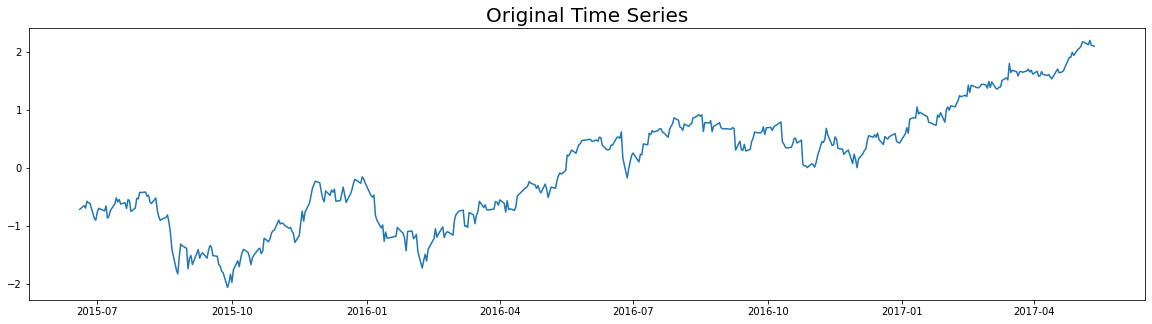

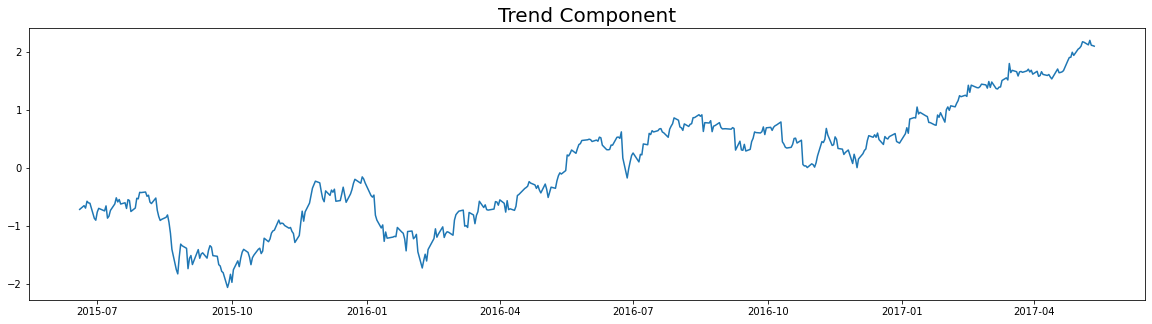

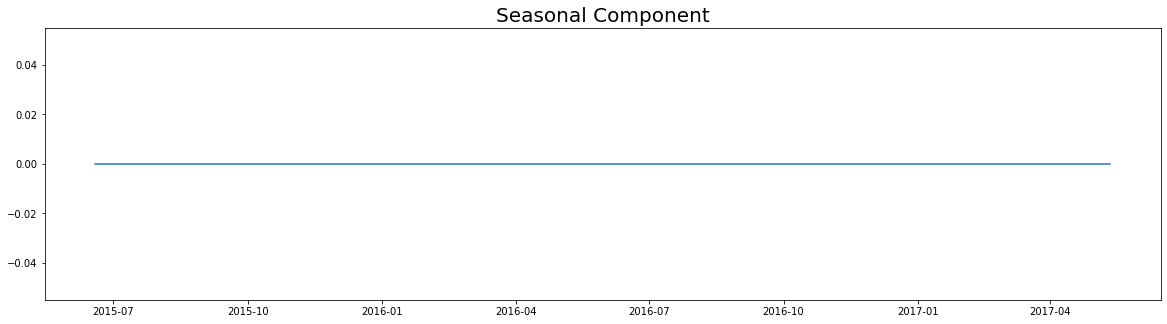

In [ ]:
decomposition = sm.tsa.seasonal_decompose(series,model='additive',freq=1)
pyplot.figure(figsize=(20,5))
pyplot.title('Original Time Series',fontsize=20)
pyplot.plot(series)
pyplot.show()
pyplot.figure(figsize=(20,5))
pyplot.title('Trend Component',fontsize=20)
pyplot.plot(decomposition.trend)
pyplot.show()
pyplot.figure(figsize=(20,5))
pyplot.title('Seasonal Component',fontsize=20)
pyplot.plot(decomposition.seasonal)
pyplot.show()

**TESTING FOR STATIONARITY**

In [ ]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    fig = pyplot.figure(figsize=(20, 5))
    orig = pyplot.plot(timeseries, color='green',label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label = 'Rolling Std')
    pyplot.title('Rolling Mean & Standard Deviation',fontsize=20)
    pyplot.show()
    
    print('Dickey-Fuller Test:')
    test = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    pvalue = test[1]
    if pvalue < cutoff:
        print('p-value = %.5f. The series is stationary.' % pvalue)
    else:
        print('p-value = %.5f. The series is non-stationary.' % pvalue)
    
    print(output)

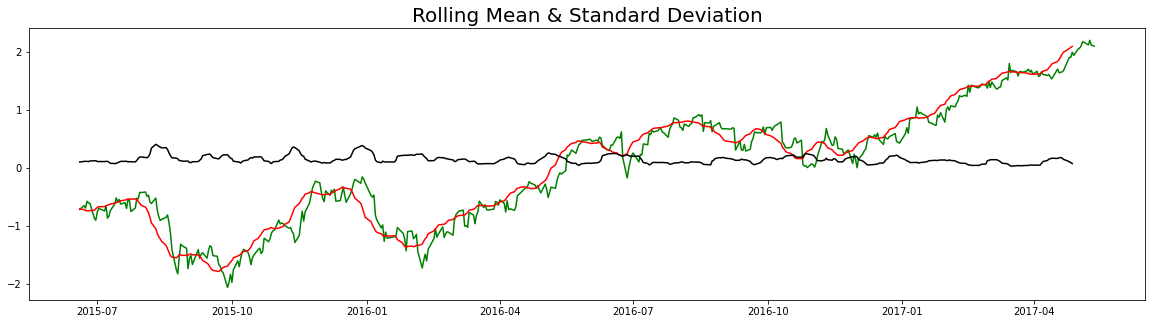

Dickey-Fuller Test:
p-value = 0.2761. The series is non-stationary.
Test Statistic                  -2.024031
p-value                          0.276137
#Lags Used                       1.000000
Number of Observations Used    477.000000
Critical Value (1%)             -3.444134
Critical Value (5%)             -2.867618
Critical Value (10%)            -2.570008
dtype: float64


In [ ]:
test_stationarity(series)

**CONVERTING INTO STATIONARY TIME SERIES**

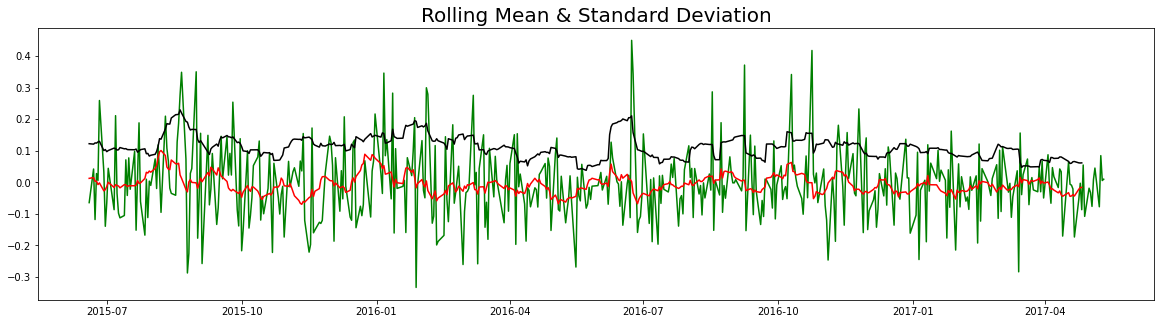

Dickey-Fuller Test:
p-value = 0.0000. The series is stationary.
Test Statistic                 -23.553575
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    477.000000
Critical Value (1%)             -3.444134
Critical Value (5%)             -2.867618
Critical Value (10%)            -2.570008
dtype: float64


In [ ]:
first_diff = series - series.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

**PLOTTING ACF AND PACF PLOTS**

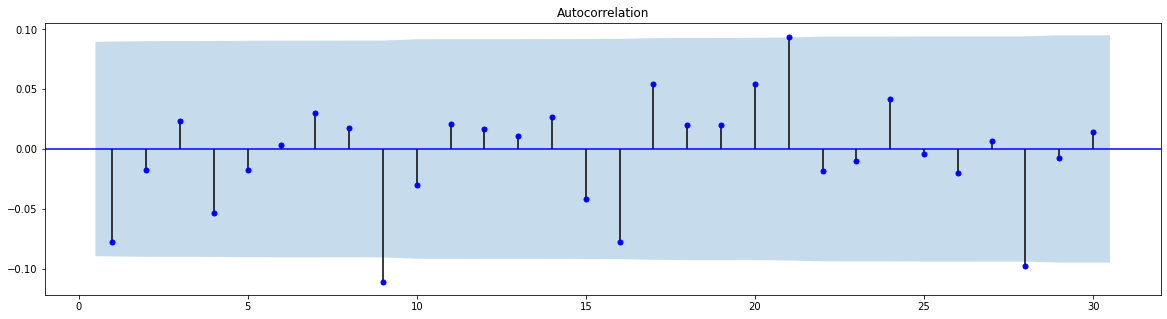

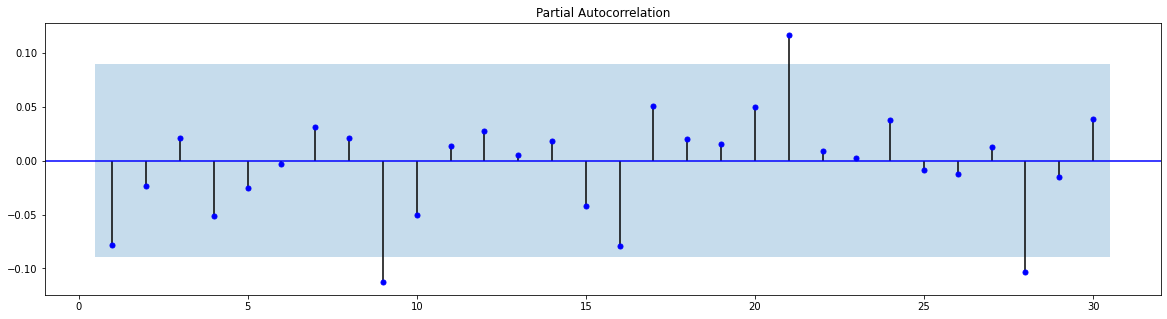

In [ ]:
fig, ax = pyplot.subplots(figsize=(20,5))
plot_acf(first_diff, lags=30, alpha=0.05, zero=False, ax=ax, color="blue")
pyplot.show()
fig, ax = pyplot.subplots(figsize=(20,5))
plot_pacf(first_diff, lags=30, alpha=0.05, zero=False, ax=ax, color="blue")
pyplot.show()

**BUILDING THE MODEL**

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  478
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 357.455
Method:                       css-mle   S.D. of innovations              0.115
Date:                Wed, 17 Nov 2021   AIC                           -706.910
Time:                        20:27:55   BIC                           -690.231
Sample:                             1   HQIC                          -700.353
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0059      0.005     -1.246      0.213      -0.015       0.003
ar.L1.D.Close     0.2116      0.765      0.277      0.782      -1.288       1.711
ma.L1.D.Close    -0.2905      0.750     

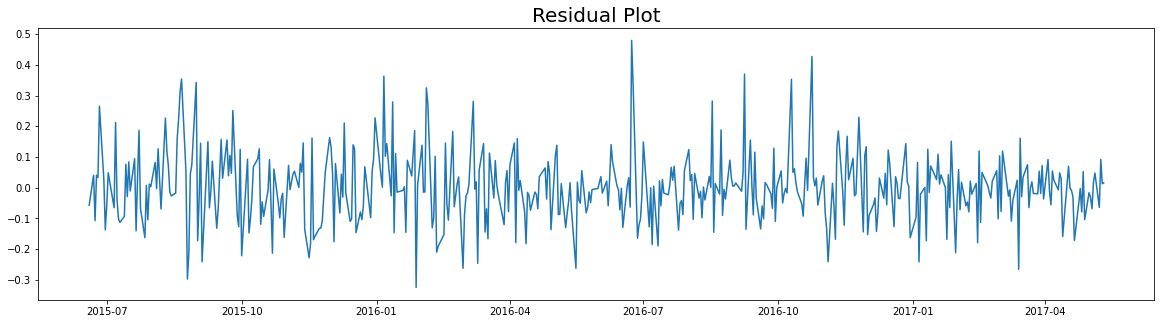

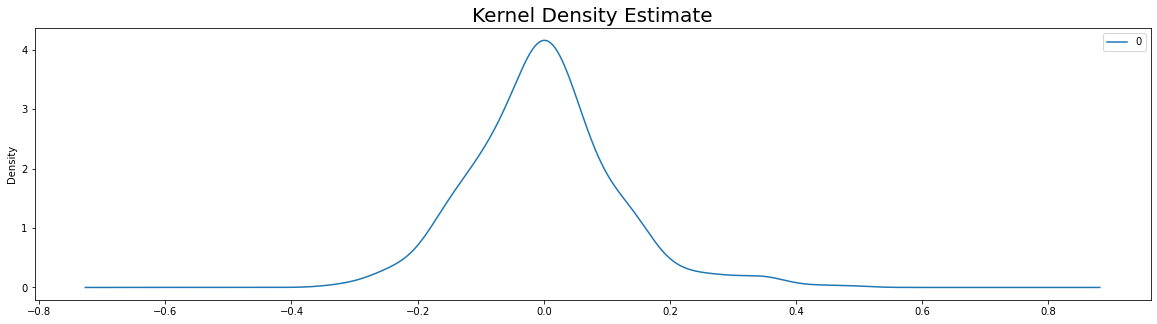

In [ ]:
model = ARIMA(series, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

residuals = DataFrame(model_fit.resid)
pyplot.figure(figsize=(20,5))
pyplot.plot(residuals)
pyplot.title('Residual Plot',fontsize=20)
pyplot.show()
residuals.plot.kde(figsize=(20,5))
pyplot.title('Kernel Density Estimate',fontsize=20)
pyplot.show()

**FORECASTING**

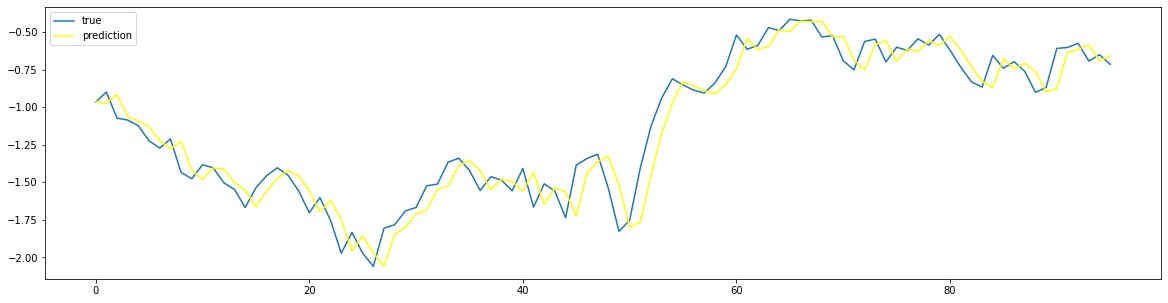

In [ ]:
size = int(len(series.values) * 0.8)
train, test = series.values[0:size], series.values[size:len(series.values)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1)) 
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

pyplot.figure(figsize=(20,5))
pyplot.plot(test,label='true')
pyplot.plot(predictions, color='yellow',label='prediction')
pyplot.legend(loc="upper left")
pyplot.show()